# **Image Classification Using the LeNet Convolutional Network**

In this notebook, the [LeNet-5](https://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf) model is implemented, one of the first published Convolutional Neural Networks (CNNs), developed by Yann LeCun and presented in 1998. The purpose of this model is to recognize handwritten digits in images. Therefore, in this notebook, LeNet-5 is trained using the [MNIST dataset](https://yann.lecun.com/exdb/mnist/), which consists of 70,000 grayscale images of handwritten digits, divided into 60,000 for training and 10,000 for testing.

## **Imports**

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from google.colab import drive

## **Parameters**

In [ ]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
epochs = 20
batch_size = 128
buffer_size = 1024
AUTOTUNE = tf.data.AUTOTUNE
SEED = 123

## **Load and Preprocess the Dataset**

In [ ]:
(train_dataset, test_dataset), info = tfds.load("mnist", split=["train", "test"], as_supervised=True, with_info=True)
info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/root/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [ ]:
num_classes = info.features["label"].num_classes
num_classes

10

In [ ]:
train_dataset = (
    train_dataset.
    map(lambda x, y: (x/255, y)). #Normalize the images in the range [0; 1]
    shuffle(buffer_size, seed=SEED).
    batch(batch_size).
    prefetch(AUTOTUNE)
)

test_dataset = (
    test_dataset.
    map(lambda x, y: (x/255, y)).
    batch(batch_size).
    prefetch(AUTOTUNE)
)

In [ ]:
# Take a batch from the training dataset
for images, labels in train_dataset.take(1):
  print(images.shape, labels.shape)

images.numpy().min(), images.numpy().max()

(128, 28, 28, 1) (128,)


(0.0, 1.0)

**Function to display and save images**

In [ ]:
def show_images(images, labels, predictions=None, num_examples=36, random=True,
                cmap="gray", axis="off", save=False, path=""):

  n = int(np.sqrt(num_examples))
  indices = np.arange(len(images))
  if random:
    np.random.shuffle(indices)

  fig, axes = plt.subplots(n, n, figsize=(1.5*n, 1.5*n))

  for i, ax in enumerate(axes.flat):
    ax.imshow(images[indices[i]], cmap=cmap)

    if predictions is not None:
      color = "#00008B" if labels[indices[i]] == predictions[indices[i]] else "red"
      ax.text(0, 1, f"Label: {labels[indices[i]]}", color=color, fontsize=7, fontweight="bold", ha="left", va="bottom", transform=ax.transAxes)
      ax.text(1, 1, f"Pred: {predictions[indices[i]]}", color=color, fontsize=7, fontweight="bold", ha="right", va="bottom", transform=ax.transAxes)
    else:
      ax.text(0.5, 1, f"Label: {labels[indices[i]]}", fontsize=7, fontweight="bold", ha="center", va="bottom", transform=ax.transAxes)

    ax.axis(axis)

  # Save images
  if save:
    plt.savefig(path)

  plt.show()

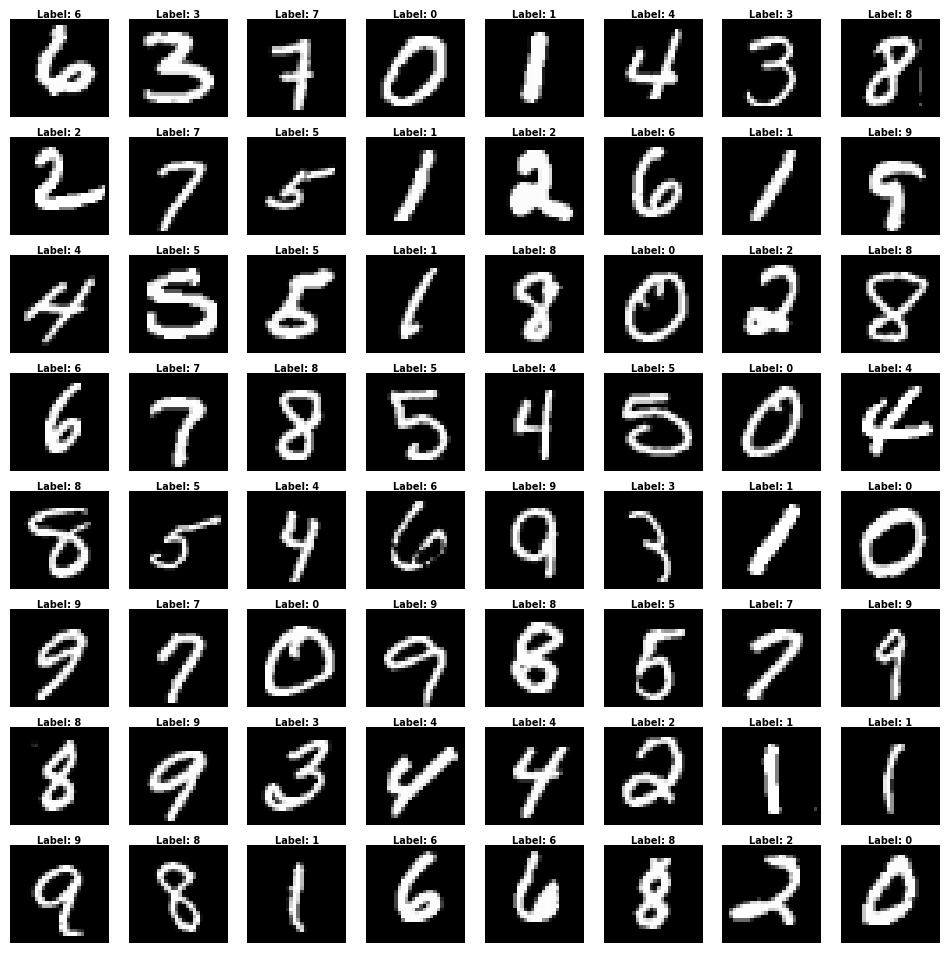

In [ ]:
# Some images from the training dataset
show_images(images, labels, num_examples=64, random=False)

## **Model Building and Training**

In [ ]:
tf.keras.backend.clear_session() #Clearing Keras memory
tf.random.set_seed(SEED) #For reproducibility

model = tf.keras.Sequential([
    tf.keras.Input(shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(6, kernel_size=5, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Conv2D(16, kernel_size=5, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation="relu"),
    tf.keras.layers.Dense(84, activation="relu"),
    tf.keras.layers.Dense(num_classes, activation="softmax")
], name="LeNet-5")

model.summary()

Model: "LeNet-5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 6)           │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 10, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,706 (241.04 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)

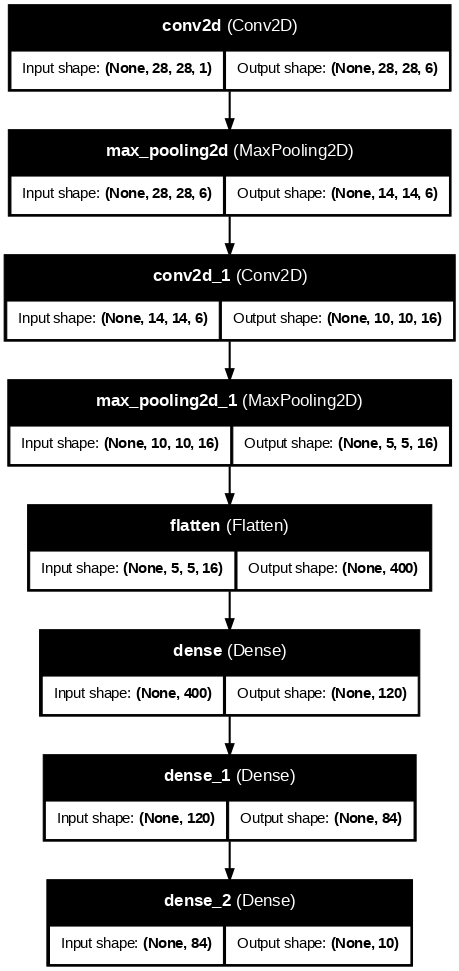

In [ ]:
# Visualizing the architecture of the model
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True, dpi=75)

In [ ]:
# Model Compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Callback to stop training early if validation accuracy does not improve for 3 epochs
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)

In [ ]:
# Train the model
tf.random.set_seed(SEED)
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=[callback])

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.8132 - loss: 0.6689 - val_accuracy: 0.9714 - val_loss: 0.0878
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9710 - loss: 0.0960 - val_accuracy: 0.9803 - val_loss: 0.0622
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9799 - loss: 0.0666 - val_accuracy: 0.9851 - val_loss: 0.0449
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9849 - loss: 0.0510 - val_accuracy: 0.9864 - val_loss: 0.0431
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9872 - loss: 0.0413 - val_accuracy: 0.9879 - val_loss: 0.0367
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9883 - loss: 0.0370 - val_accuracy: 0.9881 - val_loss: 0.0382
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9901 - loss: 0.0299 - val_accuracy: 0.9879 - val_loss: 0.0343
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9908 - loss: 0.0277 - val_accuracy: 

**Save the Model**

In [ ]:
trained_model_path = "/content/drive/MyDrive/models/ImageClassification_LeNet_MNIST.keras"
model.save(trained_model_path)

## **Model Evaluation**

In [ ]:
print(model.evaluate(train_dataset, verbose=0))
print(model.evaluate(test_dataset, verbose=0))

[0.008492027409374714, 0.9972333312034607]
[0.032237082719802856, 0.9912999868392944]


### **Graphs of the metrics**

In [ ]:
# Function to plot the metrics
def plot_metrics(history=history, metric="loss", renderer=None, epochs=len(history.history["loss"])):
  losses = history.history[metric]
  val_losses = history.history[f"val_{metric}"]
  list_epochs = np.arange(1, epochs+1)
  metric = " ".join([w.capitalize() for w in metric.split("_")])

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name=metric, line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=val_losses, name=f"Val {metric}", line=dict(color="#FF6600", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text=metric)
  fig.update_layout(title=f"Evolution of {metric} across Epochs",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

In [ ]:
# Interactive graphic
plot_metrics()
plot_metrics(metric="accuracy")

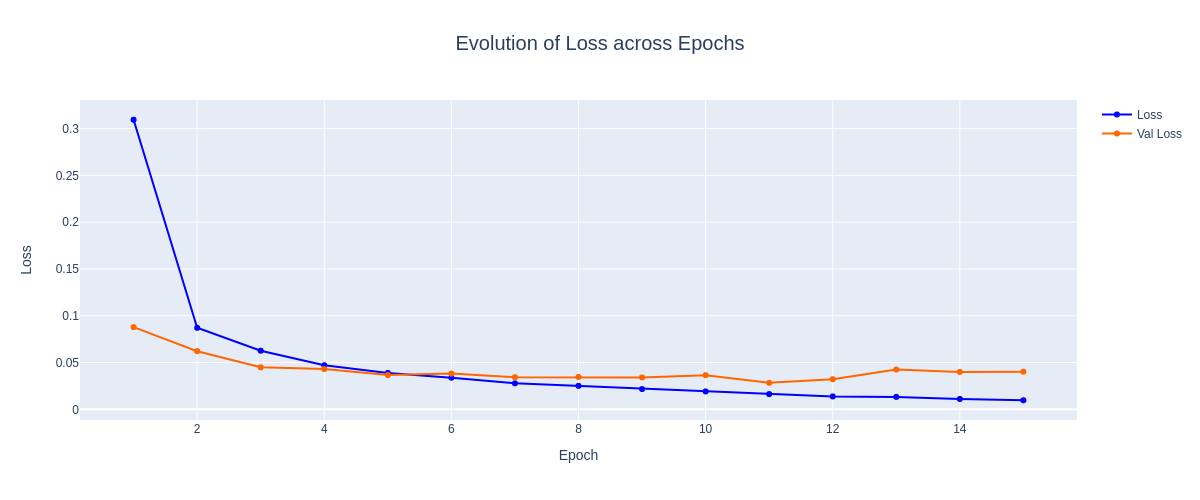

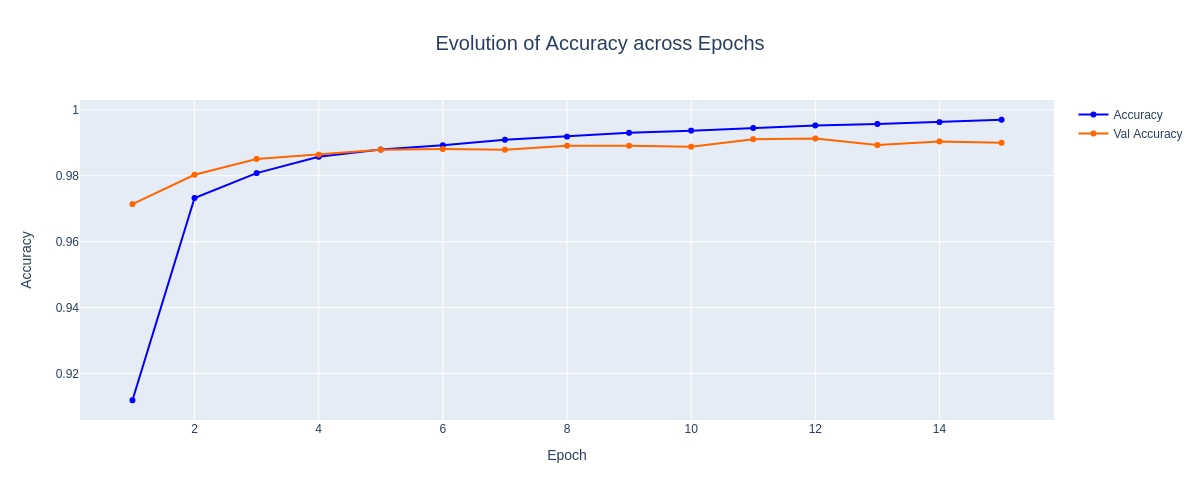

In [ ]:
# Static image for GitHub
plot_metrics(renderer="png")
plot_metrics(metric="accuracy", renderer="png")

### **Confusion Matrix**

In [ ]:
# Extract labels from the test dataset
labels_test = test_dataset.unbatch().map(lambda image, label: label)
labels_test = np.array(list(labels_test.as_numpy_iterator()))

# Generate predictions with the trained model
labels_test_pred = model.predict(test_dataset, verbose=0)
labels_test_pred = np.argmax(labels_test_pred, axis=-1)

# Consolidating the accuracy of the test dataset
np.mean(labels_test == labels_test_pred)

0.9913

Frequency per Label: [ 980 1135 1032 1010  982  892  958 1028  974 1009] 



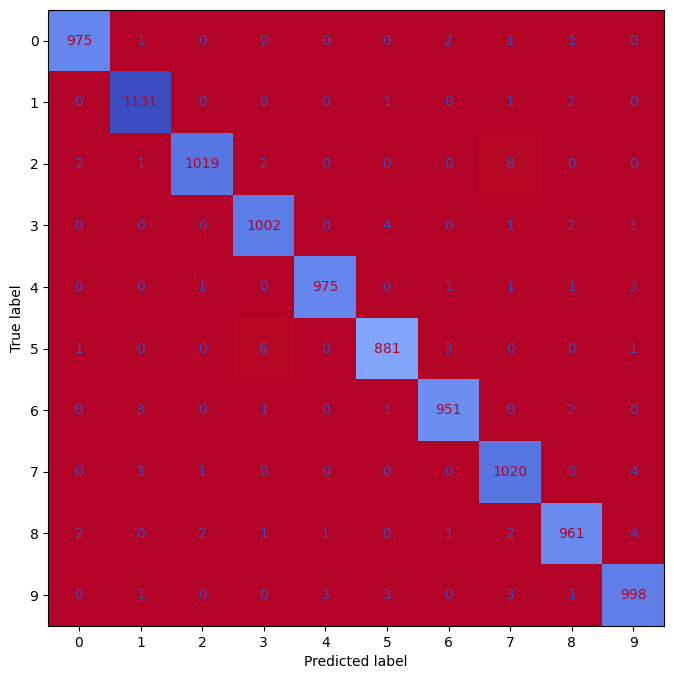

In [ ]:
print("Frequency per Label:", np.unique(labels_test, return_counts=True)[1], "\n")

cm = confusion_matrix(labels_test, labels_test_pred)
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(8, 8))
cmd.plot(ax=ax, colorbar=False, cmap="coolwarm_r");

It is observed that the model's accuracy on the training dataset is **99.72%** and on the test dataset is **99.13%** after 12 epochs. This indicates that there is no overfitting and that the model is excellent, generalizing very well and effectively learning the characteristics of handwritten digits. Of course, if training were continued for more epochs, the training accuracy would likely reach 100%, while the test accuracy would start to decrease. However, thanks to the early stopping callback, overfitting was prevented.

Additionally, the confusion matrix shows that the model makes approximately the same number of errors when predicting each of the digits (from 0 to 9), and these errors are very low, with many being zero, further consolidating the model's effectiveness.

## **Predictions on the test dataset**

In [ ]:
# Extract images from the test dataset
images_test = test_dataset.unbatch().map(lambda image, label: image)
images_test = np.array(list(images_test.as_numpy_iterator()))

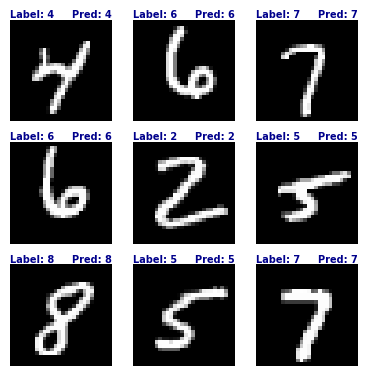

In [ ]:
show_images(images_test, labels_test, labels_test_pred, num_examples=9)

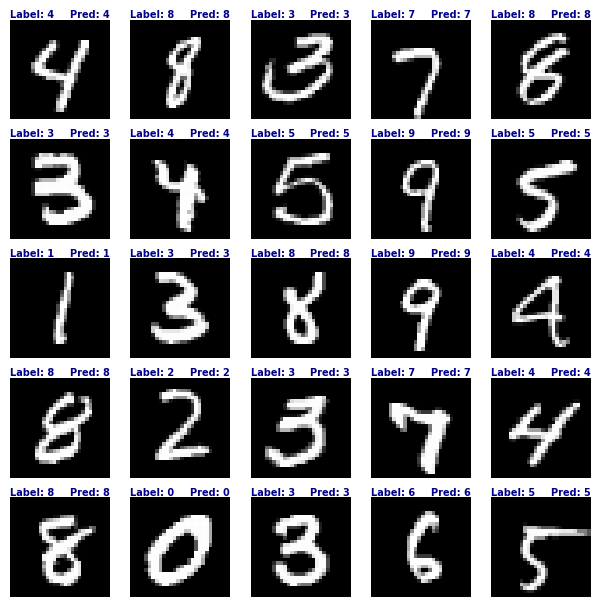

In [ ]:
show_images(images_test, labels_test, labels_test_pred, num_examples=25, save=True, path="image_LeNet_MNIST")

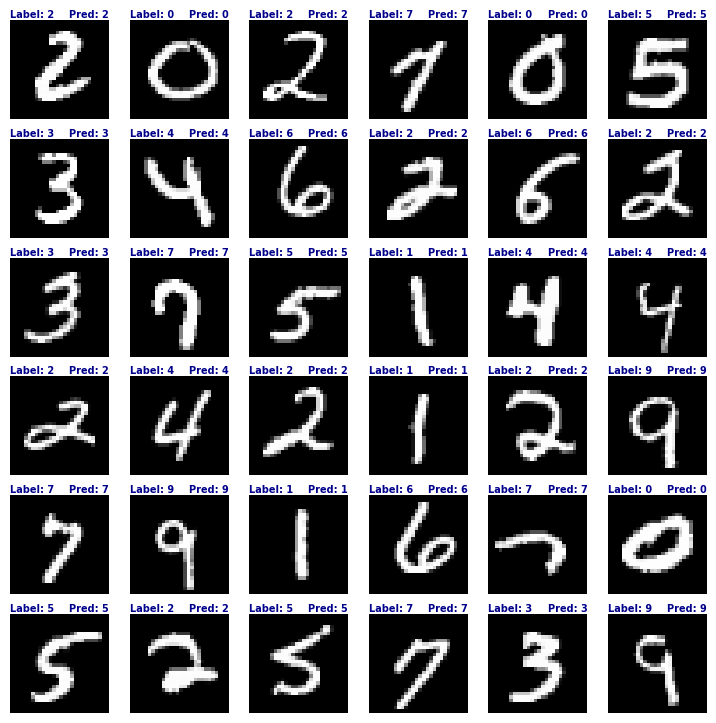

In [ ]:
show_images(images_test, labels_test, labels_test_pred)

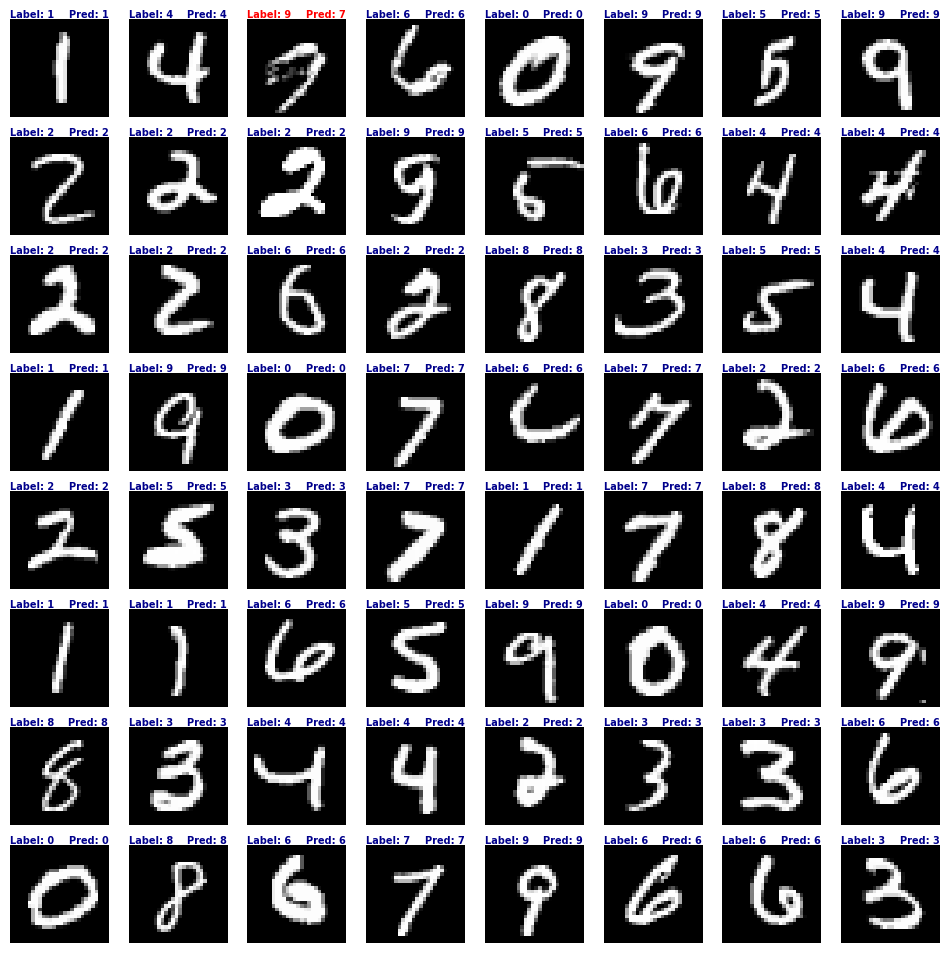

In [ ]:
# This image shows an incorrect prediction
show_images(images_test, labels_test, labels_test_pred, num_examples=64)

**Conclusion:** The LeNet-5 model is highly effective in recognizing digits in images, achieving accuracies very close to 100%. The errors made by the model are mostly due to ambiguous digits that can be challenging even for humans to identify. To achieve even better results, one could use more robust pre-trained models through transfer learning or fine-tune Vision Transformer (ViT) models, which have shown excellent performance compared to state-of-the-art convolutional networks and require substantially fewer computational resources for training. However, for the MNIST dataset, LeNet-5's performance, with accuracies over 99%, is more than sufficient.